In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator


In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/"

camera_program = 4

# Movie maker settings
enable_photoZ_interact = False
initialize_photoZ = False

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()

In [4]:
def get_stim_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_electrode.dat"

def get_ring_roi_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + "ring_roi_" +  str(slic_) + "_" + str(loc) + ".dat"

# map data files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):

    if 'notUsable' in subdir:
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = parse_date(subdir)

        # take selected zda and expand into separate subdir for each zda file
        print(os.listdir(selected_zda_dir))
        for zda_file in os.listdir(selected_zda_dir):
            if zda_file.endswith('.zda'):
                rec_id = zda_file.split('.')[0]
                print("\n", selected_zda_dir + "/" + zda_file)
                slic_id, loc_id, _ = [int(x) for x in rec_id.split("_")]

                if subdir not in data_map:
                    data_map[subdir] = {}
                if slic_id not in data_map[subdir]:
                    data_map[subdir][slic_id] = {}
                if loc_id not in data_map[subdir][slic_id]:
                    data_map[subdir][slic_id][loc_id] = {
                        'zda_files': [],
                        'stim_point_file': None,
                        'roi_files': [],
                    }
                data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)
                data_map[subdir][slic_id][loc_id]['stim_point_file'] = get_stim_filename(selected_zda_dir, slic_id, loc_id)

            if zda_file.endswith('.dat') and 'roi' in zda_file and not 'trace' in zda_file:
                slic_id, loc_id = [int(x) for x in zda_file.split(".")[0][-3:].split("_")]
                print(slic_id, loc_id, zda_file)
                roi_file = selected_zda_dir + "/" + zda_file

                if subdir not in data_map:
                    data_map[subdir] = {}
                if slic_id not in data_map[subdir]:
                    data_map[subdir][slic_id] = {}
                if loc_id not in data_map[subdir][slic_id]:
                    data_map[subdir][slic_id][loc_id] = {
                        'zda_files': [],
                        'stim_point_file': None,
                        'roi_files': [],
                    }

                data_map[subdir][slic_id][loc_id]['roi_files'].append(roi_file)


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24
['02_01_01.zda', '02_01_02.zda', '02_01_03.zda', '02_01_04.zda', '02_01_05.zda', '02_01_06.zda', '02_01_07.zda', '2_1_electrode.dat', 'Data.dat', 'ec_trace.dat', 'hidden', 'hidden_other', 'non_soma_rois_2_1.dat', 'processed_videos_timestep1', 'processed_videos_timestep4', 'ring_roi_2_1.dat', 'soma_rois_2_1.dat', 'th_trace.dat', 'trace80uA_02_01_04.dat', 'trace80uA_02_01_07.dat', 'traces_02_01_01.dat', 'trace_02_01_01.dat', 'trace_02_01_01_non_soma_rois_2_1.dat', 'trace_02_01_01_ring_roi_2_1.dat', 'trace_02_01_01_soma_rois_2_1.dat', 'trace_02_01_02.dat', 'trace_02_01_02_non_soma_rois_2_1.dat', 'trace_02_01_02_ring_roi_2_1.dat', 'trace_02_01_02_soma_rois_2_1.dat', 'trace_02_01_03.dat', 'trace_02_01_03_non_soma_rois_2_1.dat', 'trace_02_01_03_ring_roi_2_1.dat', 'trace_02_01_03_soma_rois_2_1.dat', 'trace_02_01_04.dat', 'trace_02_01_04_non_soma_rois_2_1.dat', 'trace_02_01_04_ring_roi_2_1.dat', 'trace_02_01_04_soma_rois_2

In [5]:
# now load these ROI files into PhotoZ and extract latency and halfwidth dat files
# go through the ZDA files and extract amp arrays 

lock_rois = True

if enable_photoZ_interact:
    pa.alert("Set measure window width to > 70 for half-width measurement.")
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            stim_point_file = data_map[subdir][slic_id][loc_id]['stim_point_file']

            # load stim point
            stim_file = get_stim_filename(selected_zda_dir, slic_id, loc_id)
            stim_point = ROIFileReader(stim_file).get_roi_list()
            stim_point = LaminarROI(stim_point[0], input_diode_numbers=True).get_points()[0]
            
            ring_roi_filename = get_ring_roi_filename(selected_zda_dir, slic_id, loc_id)
            if not lock_rois:
                # use stim point to create ROIs of concentric rings around the stim point
                brc = Barrel_ROI_Creator()
                new_rois = brc.get_ring_rois(stim_point, num_rings=4)

                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    new_rois[k] = [roi_cr.convert_point_to_diode_number(px) 
                                for px in new_rois[k]]
                    
                ROIFileWriter().write_regions_to_dat(ring_roi_filename, new_rois)

            # load all roi files for this slice/loc
            roi_files = data_map[subdir][slic_id][loc_id]['roi_files']

            print(roi_files)
            
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:
                print(zda_file)
                if not os.path.exists(zda_file):
                    print("ZDA file does not exist, skipping.")
                    continue
                
                if enable_photoZ_interact:
                    aPhz.open_zda_file(zda_file)

                for roi_file in roi_files:
                    roi_set_id = roi_file.split("/")[-1].split(".")[0]
                    if enable_photoZ_interact:
                        aPhz.select_roi_tab()
                        aPhz.open_roi_file(roi_file)
                        print("Opened ROI file", roi_file)

                    slic_loc_id_rec_id = zda_file.split("/")[-1].split(".")[0]
                        
                    # save half-width values from PhotoZ
                    hw_filename = subdir + "/" + "hw_" + slic_loc_id_rec_id + "_" + roi_set_id + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_half_width_trace_value()
                        aPhz.save_trace_values(hw_filename)

                    # save amp values from PhotoZ
                    amp_filename = subdir + "/" + "amp_" + slic_loc_id_rec_id + "_" + roi_set_id + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_maxamp_trace_value()
                        aPhz.save_trace_values(amp_filename)
                        
                    # save latency values from PhotoZ
                    lat_filename = subdir + "/" + "lat_" + slic_loc_id_rec_id + "_" + roi_set_id + ".dat" 
                    if enable_photoZ_interact:
                        aPhz.select_latency_trace_value()
                        aPhz.save_trace_values(lat_filename)

                    trace_filename = selected_zda_dir + "/" + "trace_" + slic_loc_id_rec_id + "_" + roi_set_id + ".dat"
                    if enable_photoZ_interact:
                        aPhz.save_current_traces(trace_filename, go_to_tab=True)

                    if roi_set_id not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][roi_set_id] = {}

                    if 'amp' not in data_map[subdir][slic_id][loc_id][roi_set_id]:
                        data_map[subdir][slic_id][loc_id][roi_set_id]['amp'] = []
                        data_map[subdir][slic_id][loc_id][roi_set_id]['hw'] = []
                        data_map[subdir][slic_id][loc_id][roi_set_id]['lat'] = []
                        data_map[subdir][slic_id][loc_id][roi_set_id]['trace'] = []
                        data_map[subdir][slic_id][loc_id][roi_set_id]['filename'] = []

                    data_map[subdir][slic_id][loc_id][roi_set_id]['amp'].append(amp_filename)
                    data_map[subdir][slic_id][loc_id][roi_set_id]['hw'].append(hw_filename)
                    data_map[subdir][slic_id][loc_id][roi_set_id]['lat'].append(lat_filename)
                    data_map[subdir][slic_id][loc_id][roi_set_id]['trace'].append(trace_filename)
                    if len(data_map[subdir][slic_id][loc_id][roi_set_id]['filename']) == 0:
                        data_map[subdir][slic_id][loc_id][roi_set_id]['filename'].append(roi_file)

['C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//non_soma_rois_2_1.dat', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//ring_roi_2_1.dat', 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//soma_rois_2_1.dat']
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_01.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_02.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_03.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_04.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_05.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_06.zda
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24/selected_zda//02_01_07.zda


In [6]:
def get_soma_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_soma.dat"

def get_non_soma_filename(selected_zda_dir, slic_, loc):
    return selected_zda_dir + str(slic_) + "_" + str(loc) + "_non_soma.dat"

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['ROI',  'Value'])
    return data_arr

def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr


# load in catalog df
catalog_df = pd.read_csv(data_dir + "theta_catalog.csv")

# put all the data into a dataframe, including time to peak calculated from trace
amp_dfs = []
for subdir in data_map:
    selected_zda_dir = subdir + "/selected_zda/"
    date = parse_date(subdir, long_year=True)
    if enable_photoZ_interact:
        aPhz = AutoPhotoZ(data_dir=subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for roi_set_id in data_map[subdir][slic_id][loc_id]:

                if roi_set_id == 'stim_point_file' or roi_set_id == 'zda_files' or roi_set_id == 'roi_files':
                    continue

                roi_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['filename'][0]

                # load rois 
                rois = ROIFileReader(roi_filename).get_roi_list()
                rois = [LaminarROI(r, input_diode_numbers=True).get_points()
                        for r in rois]
                
                # calculate distance from electrode
                distances = [Line(stim_point, roi[0]).get_length() 
                             if len(roi) > 0 
                             else None
                               for roi in rois]
                
                # load the amp, hw, and lat files
                amp_files = data_map[subdir][slic_id][loc_id][roi_set_id]['amp']
                hw_files = data_map[subdir][slic_id][loc_id][roi_set_id]['hw']
                lat_files = data_map[subdir][slic_id][loc_id][roi_set_id]['lat']
                trace_files = data_map[subdir][slic_id][loc_id][roi_set_id]['trace']

                for i in range(len(amp_files)):
                    try:
                        amp = read_dat_trace_file(amp_files[i])
                        hw = read_dat_trace_file(hw_files[i])
                        lat = read_dat_trace_file(lat_files[i])
                        trace = read_traces_file(trace_files[i])
                    except Exception as e:
                        print("Error reading file", amp_files[i], e)
                        continue

                    catalog_df_subset = catalog_df[(catalog_df['Date'] == date) &
                                                    (catalog_df['Slice'] == slic_id) &
                                                    (catalog_df['Loc'] == loc_id) & 
                                                    (catalog_df['Recording'] ==  i+1)]
                    
                    print(date, slic_id, loc_id, i+1, "of", len(amp_files))
                    
                    stim_current = catalog_df_subset['Stim_Current'].values[0]
                    electrode_type = catalog_df_subset['Electrode_Type'].values[0]
                    slice_type = catalog_df_subset['Slice_Type'].values[0]

                    # calculate time to peak
                    measure_window = [496, 596]
                    tm = TraceMetrics(trace)
                    max_amp_times = tm.get_max_amp_times(measure_window=measure_window)

                    roi_type = 'ring' if 'ring' in roi_filename else 'soma'
                    if "non_soma" in roi_filename:
                        roi_type = 'non_soma'

                    # join dataframes
                    amp = amp.join(hw, rsuffix='_hw')
                    amp = amp.join(lat, rsuffix='_lat')
                    amp.insert(4, "Distance", distances)
                    amp.insert(5, "Max_Amp_Time", max_amp_times)
                    amp.insert(6, "Stim_Current", [stim_current for _ in range(len(amp['ROI']))])
                    amp.insert(7, "Electrode_Type", [electrode_type for _ in range(len(amp['ROI']))])
                    amp.insert(8, "Date", [date for _ in range(len(amp['ROI']))])
                    amp.insert(9, "Slice", [slic_id for _ in range(len(amp['ROI']))])
                    amp.insert(10, "Loc", [loc_id for _ in range(len(amp['ROI']))])
                    amp.insert(11, "Recording", [i+1 for _ in range(len(amp['ROI']))])
                    amp.insert(12, "Slice_Type", [slice_type for _ in range(len(amp['ROI']))])
                    amp.insert(13, "ROI_Type", [roi_type for _ in range(len(amp['ROI']))])
                    amp_dfs.append(amp)

stim_time = 248.4
final_df = pd.concat(amp_dfs)
final_df['Value_lat'] -= stim_time
final_df['Max_Amp_Time'] -= stim_time  
final_df


7/19/2024 2 1 1 of 7
7/19/2024 2 1 2 of 7
7/19/2024 2 1 3 of 7
7/19/2024 2 1 4 of 7
7/19/2024 2 1 5 of 7
7/19/2024 2 1 6 of 7
7/19/2024 2 1 7 of 7
7/19/2024 2 1 1 of 7
7/19/2024 2 1 2 of 7
7/19/2024 2 1 3 of 7
7/19/2024 2 1 4 of 7
7/19/2024 2 1 5 of 7
7/19/2024 2 1 6 of 7
7/19/2024 2 1 7 of 7
7/19/2024 2 1 1 of 7
7/19/2024 2 1 2 of 7
7/19/2024 2 1 3 of 7
7/19/2024 2 1 4 of 7
7/19/2024 2 1 5 of 7
7/19/2024 2 1 6 of 7
7/19/2024 2 1 7 of 7


,ROI,Value,ROI_hw,Value_hw,Distance,Max_Amp_Time,Stim_Current,Electrode_Type,Date,Slice,Loc,Recording,Slice_Type,ROI_Type,ROI_lat,Value_lat
0,1,2.159350,1,11.17970,7.615773,4.345564,100,single,7/19/2024,2,1,1,coronal,non_soma,1,2.674
1,2,1.566970,2,12.01430,11.045361,4.350623,100,single,7/19/2024,2,1,1,coronal,non_soma,2,2.737
2,3,1.945480,3,12.52610,7.211103,3.853518,100,single,7/19/2024,2,1,1,coronal,non_soma,3,2.398
3,4,1.995180,4,8.47549,7.071068,4.350813,100,single,7/19/2024,2,1,1,coronal,non_soma,4,2.694
4,5,1.753620,5,12.00140,8.062258,4.347110,100,single,7/19/2024,2,1,1,coronal,non_soma,5,2.808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,13,0.554424,13,11.98350,11.704700,14.337140,80,single,7/19/2024,2,1,7,coronal,soma,13,3.842
13,14,0.647963,14,8.17057,6.000000,6.849032,80,single,7/19/2024,2,1,7,coronal,soma,14,3.529
14,15,0.601823,15,41.71720,14.764823,43.349855,80,single,7/19/2024,2,1,7,coronal,soma,15,4.143
15,16,0.588810,16,3.95088,15.620499,9.850763,80,single,7/19/2024,2,1,7,coronal,soma,16,7.781


In [7]:
final_df.to_csv(data_dir + "theta_final.csv")

In [8]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

In [ ]:
# plot traces
for subdir in data_map:
    print(subdir)
    date = parse_date(subdir, long_year=True)
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for roi_set_id in data_map[subdir][slic_id][loc_id]:
                if roi_set_id == 'stim_point_file' or roi_set_id == 'zda_files' or roi_set_id == 'roi_files':
                    continue

                if 'ring' not in roi_set_id:
                    continue
                    
                for i, zda_file in enumerate(data_map[subdir][slic_id][loc_id]['zda_files']):
                    amp_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['amp'][i]
                    hw_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['hw'][i]
                    lat_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['lat'][i]
                    trace_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['trace'][i]
                    sample_traces = read_traces_file(trace_filename)
                    traces_to_plot = [sample_traces]

                    # plot other traces
                    '''other_tracefilename = trace_filename.replace("trace_", "trace80uA_")
                    
                    if os.path.exists(other_tracefilename):
                        other_traces = read_traces_file(other_tracefilename)
                        traces_to_plot.append(other_traces)'''
                    
                    for trace in traces_to_plot:
                        tm = TraceMetrics(trace)
                        print(date, slic_loc_id)
                        tm.show_traces(measure_window=[500, 540], 
                                legend=False, 
                                colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                        'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                                stim_time=248.3,
                                headroom=2,
                                        )
                        tm.frequency_decomposition(measure_window=[500, 540],
                                                   xlim=[20, 400])

[60, 70, 80, 100, 120, 200] 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24


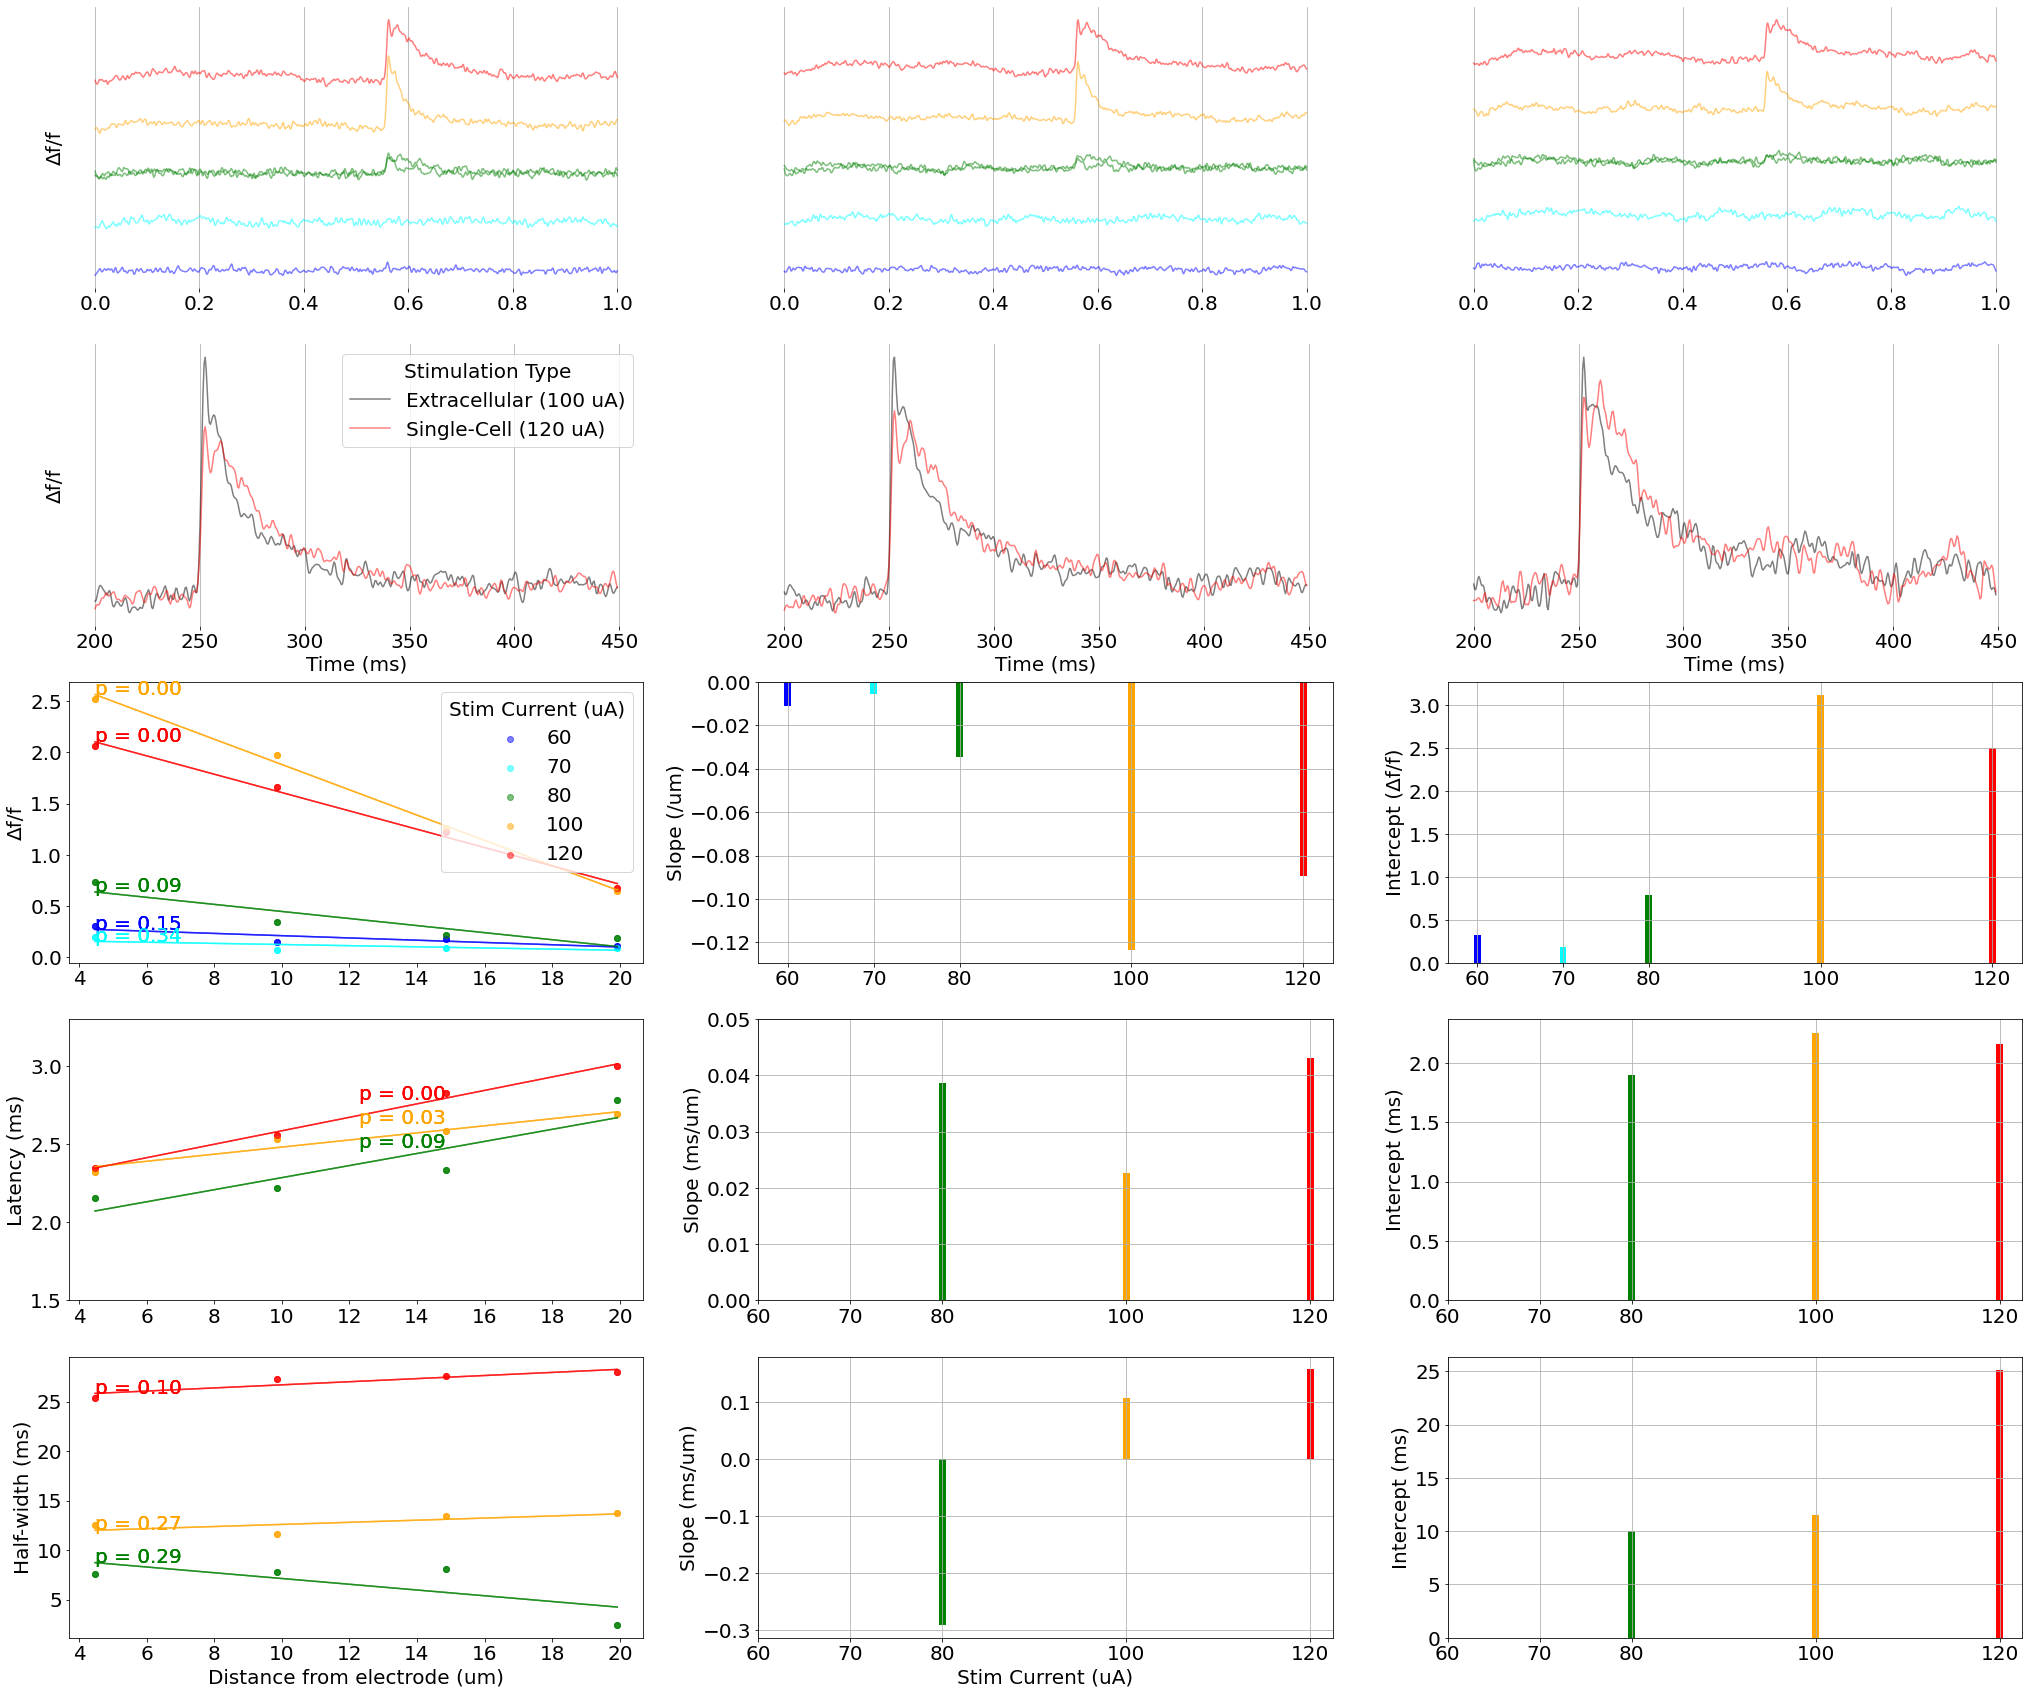

In [25]:
# set matplotlib font size to 16
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 3, figsize=(35, 30))

# color list from cold to hot
stim_color_map = {
    60: 'blue',
    70: 'cyan',
    80: 'green',
    100: 'orange',
    120: 'red',
    200: 'magenta'
}
stim_legend = {}
stim_order = list(stim_color_map.keys())
stim_order.sort()
print(stim_order, stim_order.index(80))

ax[4, 0].set_xlabel("Distance from electrode (um)")
ax[4, 1].set_xlabel("Stim Current (uA)")
ax[3, 0].set_ylim(1.5, 3.3)
headroom = 1.8
for subdir in data_map:
    print(subdir)
    date = parse_date(subdir, long_year=True)
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for roi_set_id in data_map[subdir][slic_id][loc_id]:
                if roi_set_id == 'stim_point_file' or roi_set_id == 'zda_files' or roi_set_id == 'roi_files':
                    continue
                    
                for i, zda_file in enumerate(data_map[subdir][slic_id][loc_id]['zda_files']): 
                    amp_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['amp'][i]
                    hw_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['hw'][i]
                    lat_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['lat'][i]
                    trace_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['trace'][i]
                    sample_traces = read_traces_file(trace_filename)

                    # use catalog to tell what stim current was used
                    catalog_df_subset = catalog_df[(catalog_df['Date'] == date) &
                                                    (catalog_df['Slice'] == slic_id) &
                                                    (catalog_df['Loc'] == loc_id) & 
                                                    (catalog_df['Recording'] ==  i+1)]
                    stim_current = catalog_df_subset['Stim_Current'].values[0]
                    electrode_type = catalog_df_subset['Electrode_Type'].values[0]

                    if 'ring' in roi_set_id and electrode_type == 'single':
                        color = stim_color_map[stim_current]

                        # plot the first three traces in the 3 plots of the first row
                        for j, col_name in enumerate(sample_traces.columns[1:4]):
                            x = np.linspace(0, 1, len(sample_traces['Pt']))

                            y_loc = headroom * stim_order.index(stim_current)
                            ax[0, j].plot(x, -sample_traces[col_name] + y_loc, color=color, alpha=0.5)
                            ax[0, 0].set_ylabel("Δf/f")
                            ax[0, j].set_yticks([])
                            #ax[0, j].set_xlabel("Time (ms)")
                            ax[0, j].grid(True)
                            ax[0, j].spines['top'].set_visible(False)
                            ax[0, j].spines['right'].set_visible(False)
                            ax[0, j].spines['bottom'].set_visible(False)
                            ax[0, j].spines['left'].set_visible(False)


                    # plot latency vs distance, half-width vs distance, max-amp time, and amplitude vs distance
                    # each amplitude has a different color
                    if i == 3:
                        continue  # exclude recording because it is a duplicate 80 uA stim
                    subset_df = final_df[(final_df['Date'] == date) &
                                            (final_df['Slice'] == slic_id) &
                                            (final_df['Loc'] == loc_id) &
                                            (final_df['Recording'] == i+1) & 
                                            (final_df['Electrode_Type'] == 'single')]
                    
                    roi_type = 'ring'
                    subset_df2 = subset_df[(subset_df['ROI_Type'] == 'soma') | 
                                            (subset_df['ROI_Type'] == 'non_soma')]
                    if roi_type == 'ring':
                        subset_df2 = subset_df[(subset_df['ROI_Type'] == 'ring')]

                    # scatter plot in the first column
                    for i_plotrow, response_type in enumerate(['Value', 'Value_lat', 'Value_hw']):
                        i_plotrow += 2
                        subset_df3 = subset_df2[(subset_df2[response_type] > 0) & 
                                                (subset_df2['Value'] > 0.03)]

                        for stim_current in subset_df3['Stim_Current'].unique():
                            subset_df4 = subset_df3[subset_df3['Stim_Current'] == stim_current]

                            if response_type == 'Value_lat' and stim_current == 70:
                                continue
                            if len(subset_df4) < 3:
                                continue
                            if response_type == 'Value_hw' and stim_current < 80:
                                continue

                            # 'subthreshold (≤80 uA)', 'suprathreshold (>80 uA)'
                            j_roi = 0  # if stim_current <= 80 else 1

                            
                            # linear regression for this stim current subset
                            slope, intercept, r_value, p_value, std_err = linregress(subset_df4['Distance'], subset_df4[response_type])
                            if p_value > 0.10 and response_type == 'Value_lat':
                                continue
                        
                            handle = ax[i_plotrow, j_roi].scatter(subset_df4['Distance'], subset_df4[response_type], 
                                                    color=stim_color_map[stim_current], 
                                                    label=subset_df4['Stim_Current'].values[0],
                                                    alpha=0.5)
                            
                            # plot the linear regression line
                            x = np.linspace(min(subset_df4['Distance']), max(subset_df4['Distance']), 100)
                            y = slope * x + intercept
                            ax[i_plotrow, j_roi].plot(x, y, color=stim_color_map[stim_current], alpha=0.5)

                            # label the linear regression line with the slope and p-value

                            y_annotation = i * 1/7
                            x_annotation = .84
                            xyc = 'axes fraction'
                            if response_type == 'Value' or response_type == 'Value_hw':
                                y_annotation = slope * min(subset_df4['Distance']) + intercept
                                x_annotation = min(subset_df4['Distance']  )
                                xyc = 'data'
                            if response_type == 'Value_lat':
                                y_annotation = slope * np.mean(subset_df4['Distance']  ) + intercept + 0.1
                                x_annotation = np.mean(subset_df4['Distance']  )
                                xyc = 'data'

                            ax[i_plotrow, j_roi].annotate(f"p = {p_value:.2f}", 
                                                    (x_annotation, y_annotation),
                                                    color=stim_color_map[stim_current],
                                                    xycoords=xyc)

                            stim_legend[stim_current] = handle                            
                            ax[i_plotrow, 0].set_ylabel({'Value' : 'Δf/f', 
                                                        'Value_hw': 'Half-width (ms)', 
                                                        'Value_lat': 'Latency (ms)', 
                                                        'Max_Amp_Time': 'Time to peak (ms)'}[response_type])
                            
                            # in the 2nd column, plot slope vs stim current as a bar plot
                            if response_type == 'Value_lat':
                                ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                                ax[i_plotrow, 1].set_ylabel("Slope (ms/um)")
                                ax[i_plotrow, 1].set_ylim(0, 0.05)
                                ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 1].grid(True)
                            elif response_type == 'Value':
                                ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                                ax[i_plotrow, 1].set_ylabel("Slope (/um)")
                                ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 1].grid(True)
                            elif response_type == 'Value_hw':
                                ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                                ax[i_plotrow, 1].set_ylabel("Slope (ms/um)")
                                ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 1].grid(True)

                            # in the last column, plot intercept vs stim current as a bar plot
                            if response_type == 'Value_lat':
                                ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                                ax[i_plotrow, 2].set_ylabel("Intercept (ms)")
                                ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 2].grid(True)
                            elif response_type == 'Value':
                                ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                                ax[i_plotrow, 2].set_ylabel("Intercept (Δf/f)")
                                ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 2].grid(True)
                            elif response_type == 'Value_hw':
                                ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                                ax[i_plotrow, 2].set_ylabel("Intercept (ms)")
                                ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 2].grid(True)
handle_keys = list(stim_legend.keys())
handle_keys.sort()
handles = [stim_legend[k] for k in handle_keys]
ax[2, 0].legend(handles=handles, title="Stim Current (uA)")

# for the last row, compare EC to TH at three distances
ec_trace = data_dir + "/07-19-24/selected_zda/ec_trace.dat"
th_trace = data_dir + "/07-19-24/selected_zda/th_trace.dat"
ec_trace_data = read_traces_file(ec_trace)
th_trace_data = read_traces_file(th_trace)

# th is in red, ec is in black
for i, col_name in enumerate(ec_trace_data.columns[1:4]):
    plot_start = 400
    x = ec_trace_data['Pt'] * 0.5
    l1 = ax[1, i].plot(x[plot_start:], -ec_trace_data[col_name][plot_start:], color='black', alpha=0.5)
    l2 = ax[1, i].plot(x[plot_start:], -th_trace_data[col_name][plot_start:], color='red', alpha=0.5)
    ax[1, i].set_xlabel("Time (ms)")
    ax[1, i].set_yticks([])
    ax[1, i].grid(True)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['bottom'].set_visible(False)
    ax[1, i].spines['left'].set_visible(False)
    ax[1, i].set_ylim()
ax[1, 0].legend(handles=[l1[0], l2[0]], labels=['Extracellular (100 uA)', 'Single-Cell (120 uA)'], title="Stimulation Type")
ax[1, 0].set_ylabel("Δf/f")
plt.show()


                        

In [11]:
# show ec_trace and th_trace side-by-side
ec_trace = data_dir + "/selected_zda/ec_trace.dat"
th_trace = data_dir + "/selected_zda/th_trace.dat"
ec_trace_data = read_traces_file(ec_trace)
th_trace_data = read_traces_file(th_trace)
print(ec_trace_data)
# rename the columns
ec_trace_data.columns = ['Pt', 'EC-stim-site', 'EC-surround']
th_trace_data.columns = ['Pt', 'SC-stim-site', 'SC-surround']


# combine the traces into a single dataframe
combined_trace = pd.concat([ec_trace_data, th_trace_data], axis=1)
print(combined_trace)

# drop columns that are not needed
combined_trace = combined_trace.drop(columns=['EC-surround', 'SC-surround'])

# plot the combined trace
tm = TraceMetrics(combined_trace)
tm.show_traces(measure_window=[400, 800], 
                legend=True, 
                colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                        'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                stim_time=248.3,
                headroom=0,
                )


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta//selected_zda/ec_trace.dat'

## 